In [2]:
# data processing
import pandas as pd
import numpy as np

# modelling keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# modelling sklearn
from sklearn.metrics import classification_report, auc, confusion_matrix, accuracy_score, precision_recall_curve, precision_recall_fscore_support
from sklearn.model_selection import train_test_split

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# misc
import os
import json

In [3]:
# function to load and preprocess quickdraw data
def load_quickdraw_data(dir, category_name, n_samples=1000):
    file = f'full_numpy_bitmap_{category_name}.npy'
    data = np.load(dir + file)
    if n_samples == -1:
        return data
    else:
        indices = np.random.choice(len(data), n_samples, replace=False)
        sampled_data = data[indices]
        return sampled_data

In [4]:
files = os.listdir('../data/')
categories = [file.split('_')[-1].split('.')[0] for file in files]

In [5]:
# Data directory
dir = '../data/'

# Load and preprocess data
all_data = []
labels = []

In [6]:
for category_name in categories:
    category_data = load_quickdraw_data(dir, category_name, 100) # Change this to -1 for all data
    all_data.extend(category_data)
    labels.extend([category_name] * len(category_data))

In [7]:
# split the data into training and test
x_train, x_test, y_train, y_test = train_test_split(all_data, labels, test_size=0.2, random_state=42)

print(len(all_data))

34500


In [8]:
# normalize data
x_train = np.array(x_train).astype(np.float32) / 255
x_test = np.array(x_test).astype(np.float32) / 255

# reshape
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

In [9]:
print(x_train.shape)
print(x_test.shape)

(27600, 784)
(6900, 784)


In [10]:
latent_dim = 2

In [11]:
# encoder
vae_input = Input(shape=(784,))
x = Dense(256, activation='relu')(vae_input)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

In [12]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean), mean=0., stddev=1.0)
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [13]:
z = Lambda(lambda x: sampling(x))([z_mean, z_log_var])

In [14]:
# decoder
decoder_input = Input(shape=(latent_dim,))
x = Dense(128, activation='relu')(decoder_input)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dense(784, activation='sigmoid')(x)
decoded = x

In [15]:
# Encoder model
encoder = Model(inputs=vae_input, outputs=[z_mean, z_log_var, z])

# Decoder model
decoder = Model(inputs=decoder_input, outputs=decoded)

In [16]:
vae_output = decoder(encoder(vae_input)[2])
vae = Model(inputs=vae_input, outputs=vae_output)

In [17]:
def vae_loss(x, x_decoded_mean):
    reconstruction_loss = tf.reduce_mean(tf.square(x - x_decoded_mean))
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = -0.5 * tf.reduce_mean(kl_loss, axis=-1)
    vae_loss = reconstruction_loss + kl_loss
    return vae_loss

vae.add_loss(vae_loss(vae_input, vae_output))

In [18]:
# Adding early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [19]:
vae.compile(optimizer='adam')

In [20]:
# Adding the early stopping callback to the fit method
history = vae.fit(x_train, x_train, epochs=100, batch_size=64, validation_data=(x_test, x_test), callbacks=[early_stopping])

Epoch 1/100
432/432 [==============================] - 3s 5ms/step - loss: 0.1025 - val_loss: 0.0933
Epoch 2/100
432/432 [==============================] - 2s 5ms/step - loss: 0.0932 - val_loss: 0.0932
Epoch 3/100
432/432 [==============================] - 2s 5ms/step - loss: 0.0930 - val_loss: 0.0932
Epoch 4/100
432/432 [==============================] - 2s 5ms/step - loss: 0.0929 - val_loss: 0.0932
Epoch 5/100
432/432 [==============================] - 2s 5ms/step - loss: 0.0928 - val_loss: 0.0932
Epoch 6/100
432/432 [==============================] - 2s 5ms/step - loss: 0.0928 - val_loss: 0.0931
Epoch 7/100
432/432 [==============================] - 2s 5ms/step - loss: 0.0927 - val_loss: 0.0932
Epoch 8/100
432/432 [==============================] - 2s 5ms/step - loss: 0.0927 - val_loss: 0.0931
Epoch 9/100
432/432 [==============================] - 2s 5ms/step - loss: 0.0927 - val_loss: 0.0931
Epoch 10/100
432/432 [==============================] - 2s 5ms/step - loss: 0.0927 - val_lo

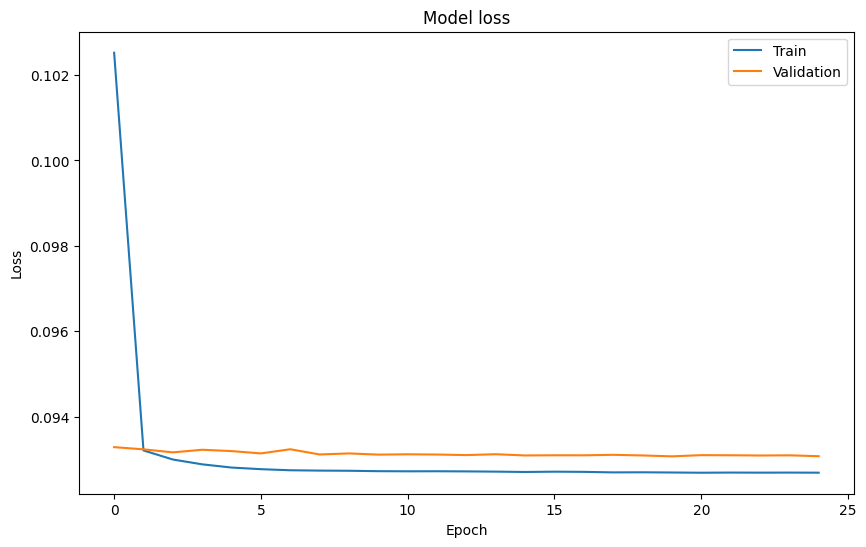

In [21]:
# Plot training history
plt.figure(figsize=(10, 6))

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [22]:
decoded_images = vae.predict(x_test)

# calculate the reconstruction error for each sample
reconstruction_errors = np.mean(np.square(x_test - decoded_images), axis=1)

216/216 [==============================] - 0s 1ms/step


In [23]:
# define a threshold for anomaly detection
threshold = np.percentile(reconstruction_errors, 95)

# Identify anomalies based on the threshold
anomaly_indexes = np.where(reconstruction_errors > threshold)[0]

In [24]:
# Get corresponding labels for anomaly indexes
anomaly_labels = [y_test[i] for i in anomaly_indexes]

# Print or use anomaly_indexes and anomaly_labels as needed
print("Anomaly Indexes:", anomaly_indexes)
print("Anomaly Labels:", anomaly_labels)

Anomaly Indexes: [   0   17   47   67   84  112  133  134  166  195  199  219  242  248
  253  279  283  294  329  345  377  433  486  488  496  541  542  543
  547  568  587  592  602  604  610  622  630  652  703  718  732  737
  761  763  765  774  822  827  847  851  862  924  930  948  989  995
 1015 1027 1082 1095 1115 1126 1135 1148 1154 1161 1163 1194 1222 1223
 1231 1236 1245 1318 1324 1377 1387 1396 1435 1456 1464 1478 1481 1509
 1546 1611 1615 1620 1630 1638 1639 1649 1696 1701 1725 1786 1798 1835
 1839 1840 1859 1886 1894 1923 1964 1970 1976 1993 2012 2061 2069 2126
 2167 2173 2198 2220 2237 2264 2276 2285 2294 2358 2365 2371 2412 2451
 2471 2483 2509 2510 2519 2534 2545 2560 2619 2633 2697 2727 2734 2740
 2743 2750 2762 2765 2834 2849 2852 2854 2869 2885 2904 2922 2977 2990
 3000 3024 3029 3067 3089 3093 3100 3125 3169 3183 3197 3200 3204 3206
 3232 3247 3276 3278 3345 3353 3355 3357 3372 3382 3410 3418 3437 3477
 3541 3588 3596 3614 3628 3630 3653 3669 3674 3693 3713 3716

In [25]:
# Get all the anomalies from the test_images
anomalies = x_test[anomaly_indexes]

print(len(anomalies))

345


In [26]:
# Get anomaly labels
anomaly_indexes = np.array(anomaly_indexes, dtype=int)
label_of_anomalies = [y_test[i] for i in anomaly_indexes]

# create a dict of indexes and labels
anomaly_dict = dict(zip(map(int, anomaly_indexes), label_of_anomalies))

In [27]:
anomaly_dict_serializable = {int(key): str(value) for key, value in anomaly_dict.items()}

In [28]:
# write to json file
json_filename = "anomalies.json"
with open(json_filename, 'w') as json_file:
    json.dump(anomaly_dict_serializable, json_file)

print(f"Anomaly dictionary saved to {json_filename}")

Anomaly dictionary saved to anomalies.json


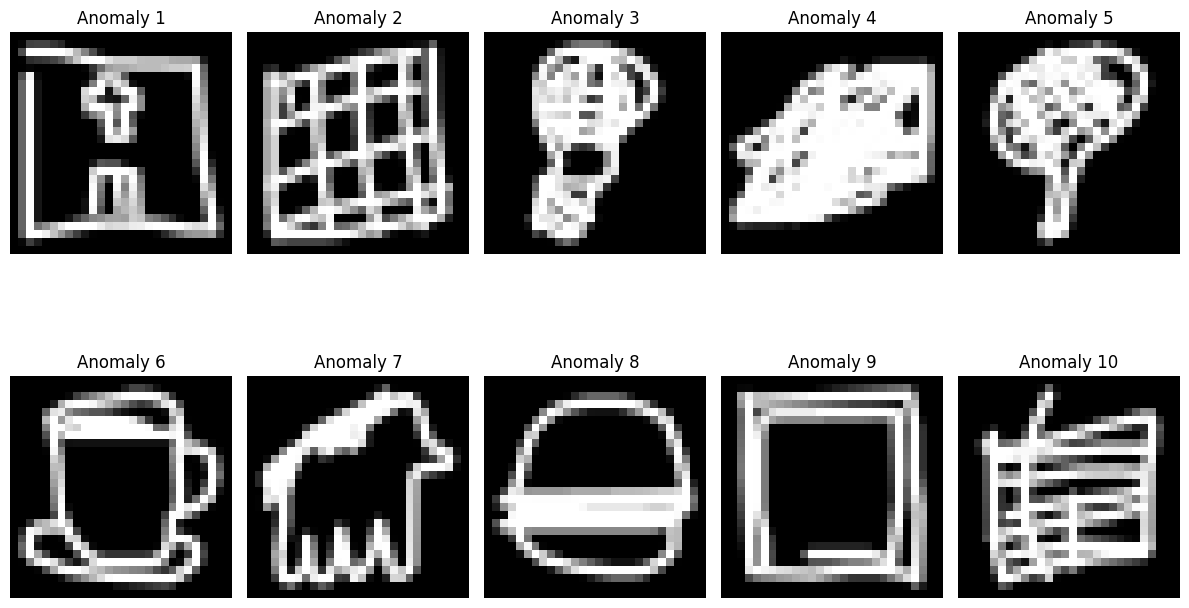

In [29]:
# Plot some of the anomalies
plt.figure(figsize=(12, 8))
for i, idx in enumerate(anomaly_indexes[:10]):  # Plot the first 10 anomaly indices
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f'Anomaly {i+1}')
    plt.axis('off')
plt.tight_layout()
plt.show()

c:\Users\zippe\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


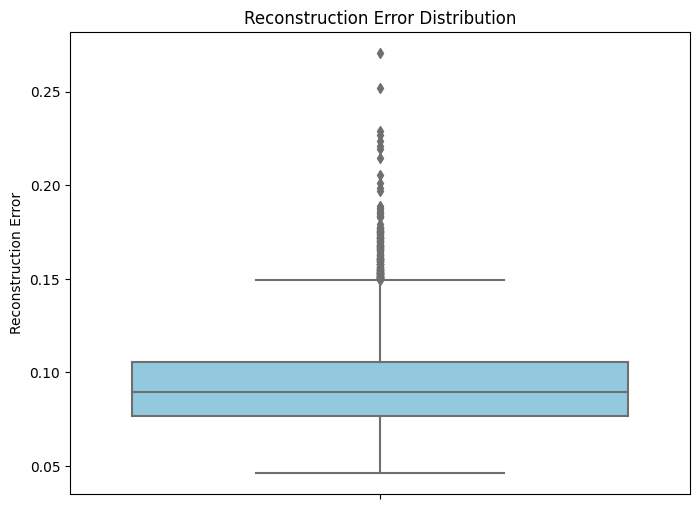

In [30]:
# Plot a boxplot of the reconstruction errors
plt.figure(figsize=(8, 6))
sns.boxplot(y=reconstruction_errors, color='skyblue')
plt.title('Reconstruction Error Distribution')
plt.ylabel('Reconstruction Error')
plt.show()

In [31]:
# Convert labels to binary numeric format
y_test_binary = [1 if label in anomaly_labels else 0 for label in y_test]

In [32]:
# Evaluate performance metrics
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test_binary, 
                                                                 [1 if i in anomaly_indexes else 0 for i in range(len(y_test_binary))],
                                                                 average='binary')
accuracy = accuracy_score(y_test_binary, [1 if i in anomaly_indexes else 0 for i in range(len(y_test_binary))])


In [33]:
# Print or use metrics as needed
# print precision, recall, and f1 score
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print("Accuracy:", accuracy)

Precision: 1.0
Recall: 0.13833199679230151
F1 Score: 0.2430433251144769
Accuracy: 0.6885507246376812


In [34]:
# Generate classification report
report = classification_report(y_test_binary,
                                     [1 if i in anomaly_indexes else 0 for i in range(len(y_test_binary))],
                                     target_names=['Normal', 'Anomaly'])

# Print or use the classification report as needed
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

      Normal       0.67      1.00      0.80      4406
     Anomaly       1.00      0.14      0.24      2494

    accuracy                           0.69      6900
   macro avg       0.84      0.57      0.52      6900
weighted avg       0.79      0.69      0.60      6900



In [35]:
# Get precision and recall values
precision, recall, _ = precision_recall_curve(y_test_binary, reconstruction_errors)

# Calculate PR-AUC
pr_auc = auc(recall, precision)

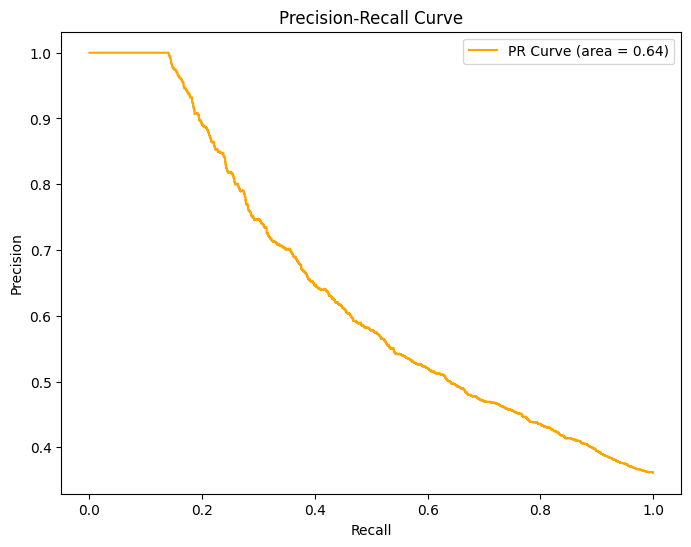

In [36]:
# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='orange', label='PR Curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [37]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_binary, [1 if i in anomaly_indexes else 0 for i in range(len(y_test_binary))])

In [38]:
print(conf_matrix)

[[4406    0]
 [2149  345]]


In [39]:
tn, fp, fn, tp = conf_matrix.ravel()
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

True Negatives: 4406
False Positives: 0
False Negatives: 2149
True Positives: 345
